In [263]:
import pandas as pd
import numpy as np 
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb



In [264]:
Data_to_add = pd.read_csv('../Datasets originales/Df_sold_homes_to_add.csv')

In [265]:
propertys_ids_to_add = Data_to_add['property_id'].to_list()

In [266]:
Houses_for_sale = pd.read_csv('../Dataset limpios/Houses_for_sale_processed.csv')

In [267]:
Data = pd.read_csv('../Dataset limpios/Houses_sold_processed.csv')

In [268]:
dicts = []
for id in propertys_ids_to_add:
    
    if id not in Data['property_id'].to_list():
        dict = Houses_for_sale[Houses_for_sale['property_id']==id].to_dict()
        dicts.append(dict)

In [269]:
print(f'''Hay un total de {len(propertys_ids_to_add)} ids para añadir al dataset de entrenamiento de los cuales \n
      {len(dicts)} no estaban ya en el dataset''')

Hay un total de 6662 ids para añadir al dataset de entrenamiento de los cuales 

      6650 no estaban ya en el dataset


In [270]:
dfs = []
for dict in dicts: 
    df = pd.DataFrame(dict)
    dfs.append(df)
Data_to_add = pd.concat(dfs,ignore_index=True)

In [271]:
Data_to_add.head(2)

,property_id,lon,lat,postal_code,state,city,state_code,line,fips_code,name,...,beds,type,primary_photo,tags,list_date,photos,list_price,listing_id,primary,status
0,1000163193,-122.340542,37.94899,94804,California,Richmond,CA,2814 Lowell Ave,6013.0,Contra Costa,...,2.0,single_family,https://ap.rdcpix.com/c40746b359c3d70b1696f82f...,"['central_air', 'community_outdoor_space', 'di...",2023-09-16,https://ap.rdcpix.com/c40746b359c3d70b1696f82f...,899000.0,2.959741e+09,True,for_sale
1,1000748625,-122.196956,47.91802,98208,Washington,Everett,WA,8729 Del Campo Dr,53061.0,Snohomish,...,4.0,single_family,https://ap.rdcpix.com/7501bd1b85a32ead25dd46b5...,"['basement', 'community_outdoor_space', 'dinin...",2023-09-27,https://ap.rdcpix.com/7501bd1b85a32ead25dd46b5...,870000.0,2.960037e+09,True,for_sale


In [272]:
Data_complete = pd.concat([Data,Data_to_add], ignore_index=True)

In [273]:
columns = ['state_code', 'line','postal_code', 'state','name']
Data_complete.drop(columns = columns, inplace=True)

In [274]:
columns = ['street_view_url', 'primary_photo','photos', 'listing_id']
Data_complete.drop(columns = columns, inplace=True)

In [275]:
def year():#return current year
    
    current_time = time.time()

    time_structure = time.localtime(current_time)

    
    current_year = time_structure.tm_year

    return current_year

In [276]:
def get_age(year_text):

    current_year = year()

    return current_year - year_text 

In [277]:
Data_complete['year_built'] = Data_complete['year_built'].apply(get_age)

In [278]:
Data_complete.drop(columns='status',inplace = True)

In [279]:
Data_complete.drop('primary', axis=1,inplace = True)

In [280]:
label_encoder = LabelEncoder()


In [281]:
Data_complete['encoded_city'] = label_encoder.fit_transform(Data_complete['city'])
Data_complete.drop(columns='city', inplace = True)

In [282]:
Data_complete['encoded_type'] = label_encoder.fit_transform(Data_complete['type'])
Data_complete.drop(columns='type', inplace = True)

In [283]:
top_50_tags = pd.read_csv('most_commun_tags.csv')

In [284]:
my_ref_list = top_50_tags['tag'].to_list()

    # Iterate through each column
for column in Data_complete[['tags']]:
    # Initialize a dictionary to store One-Hot Encoding results
    encoding_dict = {}
    
    # Iterate through each value in the column's list
    for value in my_ref_list:
        # Check if the value is in the list
        encoding_dict[f'{value}'] = [int(isinstance(lst, list) and value in lst) for lst in Data_complete[column]]
    
    # Create a new DataFrame from the encoding_dict
    encoding_df = pd.DataFrame(encoding_dict)


Data_complete = Data_complete.reset_index().drop(columns='index')
# Concatenate the dataframes side by side
result = pd.concat([Data_complete, encoding_df], axis=1)

In [285]:
result.drop(columns='tags', inplace=True)

In [286]:
result.set_index('property_id',inplace=True)

In [287]:
def convert_bools(value):
    try:
        value = int(value)
    except:
        value=value
    return value

In [288]:
result['is_new_construction'] = result['is_new_construction'].apply(convert_bools)

In [289]:
for column in result.columns:
    if 'is_' in column:
        result[column] = result[column].apply(convert_bools)

In [290]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17746 entries, 1000385902 to 9993679106
Data columns (total 71 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   lon                          17590 non-null  float64
 1   lat                          17590 non-null  float64
 2   fips_code                    16994 non-null  float64
 3   is_new_construction          118 non-null    float64
 4   is_for_rent                  0 non-null      float64
 5   is_contingent                215 non-null    float64
 6   is_price_reduced             2240 non-null   float64
 7   is_foreclosure               49 non-null     float64
 8   is_plan                      0 non-null      float64
 9   is_coming_soon               206 non-null    float64
 10  year_built                   16856 non-null  float64
 11  lot_sqft                     15550 non-null  float64
 12  sqft                         16470 non-null  float64
 13  baths  

In [291]:
result.drop(columns='list_date', inplace=True)

In [292]:
result.dropna(subset='list_price', inplace=True)

In [293]:
price = result[['list_price']].reset_index().sort_values(by='property_id').reset_index().drop(columns='index').set_index('property_id')

In [294]:
# Define a window size
window_size = 100

# Set the sigma value, which is 3, although a slightly larger value could be chosen due to data dispersion
sigma = 8

# Define the  ceiling of the graph
price['ceiling'] = price['list_price'].rolling(window=window_size).mean() + (sigma * price['list_price'].rolling(window=window_size).std())

<Axes: xlabel='property_id'>

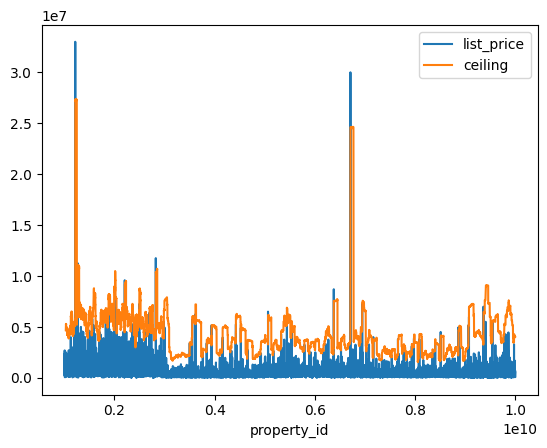

In [295]:
price.plot()

<Axes: xlabel='property_id'>

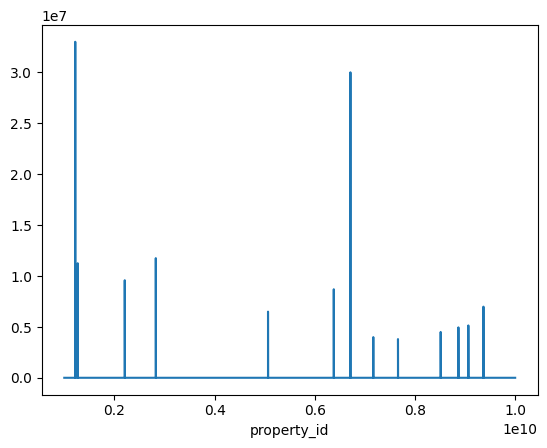

In [296]:
price['anomaly']=price.apply(
    lambda row: row['list_price'] if (row['list_price']>=row['ceiling']) else 0, axis=1
)
price['anomaly'].plot()

In [297]:
price[price['anomaly']!=0]

,list_price,ceiling,anomaly
property_id,,,
1219585460,33000000.0,2.734582e+07,33000000.0
1268210483,11250000.0,1.076620e+07,11250000.0
2207162835,9580000.0,9.091289e+06,9580000.0
2826711544,11750000.0,1.017990e+07,11750000.0
5066580275,6495000.0,6.112833e+06,6495000.0
6378956752,8695000.0,7.565816e+06,8695000.0
6711130841,29999999.0,2.459210e+07,29999999.0
7167802095,3995000.0,3.724739e+06,3995000.0
7660300475,3800000.0,3.726686e+06,3800000.0


In [298]:
anomalous_ids = price[price['anomaly']!=0].reset_index()['property_id'].to_list()

In [299]:
result.drop(anomalous_ids, inplace=True)

In [300]:
result.drop(columns='is_for_rent',inplace=True)

In [301]:
result.to_csv('Dataset_modelo_csv.csv')